In [1]:
import numpy                as np
import pandas               as pd
import seaborn              as sns
import matplotlib.pyplot    as plt
import matplotlib.ticker    as mtick

from   matplotlib.lines     import Line2D
from   matplotlib.patches   import Patch
from   matplotlib.gridspec  import GridSpec
from   scipy.stats          import pearsonr

from   model.user_item_dataset          import UserItemDataset

In [2]:
# PLOTTING CONFIGURATIONS
# enable inline plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # set format to svg for better resolution
# sns.set_theme() # apply default theme in seaborn

In [3]:
# TODO:
#    - Make temporary cystomizing using 'plt.style.context()'
# pdf formatting parameters
plt.rc('font', size=18)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('legend', title_fontsize=20)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=15)

## Dataset loading

*It's used for correlation calculations*

In [5]:
## Read items in pandas

# Read all genres
with open('../datasets/ml-100k/u.genre') as f:
    genres = [l.split('|')[0] for l in f.readlines()]

# Make list with column names
cols = ['id', 'title', 'date', 'garbage', 'url'] + genres
# Read items file in pandas
items_df = pd.read_csv('../datasets/ml-100k/u.item', sep='|', encoding='ISO-8859-1', names=cols, header=None)
items_df.drop(['garbage', 'url'], axis=1, inplace=True)

# Keep only Action and Romance
items_df = items_df.loc[(items_df['Action'] == 1) | (items_df['Romance'] == 1)]# Load dataset
my_dataset = UserItemDataset()
my_dataset.load_data(info_filepath='../datasets/ml-100k/u.info',
                     users_filepath='../datasets/ml-100k/u.user',
                     items_filepath='../datasets/ml-100k/u.item',
                     genres_filepath='../datasets/ml-100k/u.genre',
                     ratings_filepath='../datasets/ml-100k/u.data')

genres_of_interest = ['Action', 'Romance']

user_original_ids, item_original_ids, R = my_dataset.filter_interactions_by_genre(genres_of_interest,
                                                                                  exclusive=True)

users_num, items_num = R.shape[0], R.shape[1]

# Seperate item group mapped ids for group 0 and group 1
item_group_mapped_ids_0, item_group_mapped_ids_1 = [], []
for i in range(item_original_ids.shape[0]):
    if my_dataset.is_genre(item_original_ids[i], genres_of_interest[0]):
        item_group_mapped_ids_0.append(i)
    else:
        item_group_mapped_ids_1.append(i)

# Transform to numpy arrays
item_group_mapped_ids_0, item_group_mapped_ids_1 = np.array(item_group_mapped_ids_0), np.array(item_group_mapped_ids_1)

male_mapped_ids = np.array([i for i in range(users_num) if my_dataset.is_male(user_original_ids[i])])
female_mapped_ids = np.array([i for i in range(users_num) if not my_dataset.is_male(user_original_ids[i])])

## Read items in pandas

In [65]:
# Read all genres
with open('../datasets/ml-100k/u.genre') as f:
    genres = [l.split('|')[0] for l in f.readlines()]

# Make list with column names
cols = ['id', 'title', 'date', 'garbage', 'url'] + genres
# Read items file in pandas
items_df = pd.read_csv('../datasets/ml-100k/u.item', sep='|', encoding='ISO-8859-1', names=cols, header=None)
items_df.drop(['garbage', 'url'], axis=1, inplace=True)

# Keep only Action and Romance
items_df = items_df.loc[(items_df['Action'] == 1) | (items_df['Romance'] == 1)]

# Invividual-level

## Experiment 1

---

## Average delta

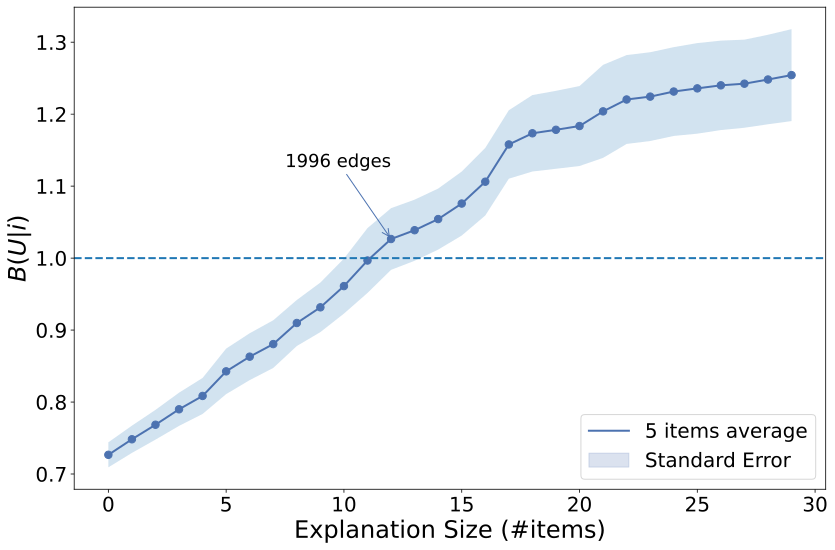

In [6]:
exp_dir = './output/full/individual_item_side/exp1'
# exp_filename = 'exp1_5_50_a_1_avg_delta'
# exp_filename = 'exp1_5_50_a_1_avg_diff'
# exp_filename = 'exp1_5_50_a_1_sum_delta'
# exp_filename = 'exp1_5_50_a_1_sum_diff'
exp_filename = 'exp1_5_30_a_1_sum_delta'
output_dir = './plots/full/individual_item_side/exp1'
output_format = 'png'

calculate_increase = False
x_values_limit = -1

fairness_value = 1

colors = sns.color_palette('deep')

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(7): f.readline() # Skip header lines
    
    # Read data
    lines = f.readlines()
    item_i_ids = np.array([int(lines[i]) for i in range(0, len(lines), 6)]) # Read item i ids
    group_0_initial_ppr_all = np.array([float(lines[i].split()[0]) for i in range(1, len(lines), 6)]) # Read initial p_{U_0}(i)
    group_1_initial_ppr_all = np.array([float(lines[i].split()[1]) for i in range(1, len(lines), 6)]) # Read initial p_{U_1}(i)
    group_0_new_ppr_all = np.array([np.array([float(j) for j in lines[i].split()])[:x_values_limit]
                                    for i in range(3, len(lines), 6)]) # Read new p_{U_0}(i)
    group_1_new_ppr_all = np.array([np.array([float(j) for j in lines[i].split()])[:x_values_limit]
                                    for i in range(4, len(lines), 6)]) # Read new p_{U_0}(i)
    item_x_removed_ids_all = np.array([np.array([int(j) for j in lines[i].split()])[:x_values_limit]
                                       for i in range(5, len(lines), 6)]) # Read item x ids

# Add initial scores to the array
scores_0_all = np.insert(group_0_new_ppr_all, 0, group_0_initial_ppr_all, axis=1)
scores_1_all = np.insert(group_1_new_ppr_all, 0, group_1_initial_ppr_all, axis=1)

# Calculate betas
beta_all = scores_0_all/scores_1_all

if calculate_increase:
    y_values_all = np.array([(beta_all[i] - beta_all[i, 0])/beta_all[i, 0] for i in range(beta_all.shape[0])])
else:
    y_values_all = beta_all
    
y_values_avg = np.mean(y_values_all, axis=0)

# Calculate average alpha overall and beta per explanation size
# item_mapped_ids = np.in1d(item_original_ids, item_i_ids).nonzero()[0]
# alpha_avg = np.mean(np.mean(R[male_mapped_ids[:, np.newaxis], item_mapped_ids], axis=0)/(
#                     np.mean(R[female_mapped_ids[:, np.newaxis], item_mapped_ids], axis=0)))

fairness_ind = np.argmax(y_values_avg > fairness_value)

if calculate_increase:
#     alpha_avg = alpha_avg/np.mean(beta_all[:, 0]) - 1 # Transform alpha_avg in percentage
    fairness_value = fairness_value/np.mean(beta_all[:, 0]) - 1
    
item_x_U_0_nbs = np.array([np.array([np.count_nonzero(R[male_mapped_ids, np.where(item_original_ids == j)[0][0]])
                                      for j in item_x_removed_ids_all[i]])
                                                     for i in range(item_x_removed_ids_all.shape[0])])

item_x_U_0_nbs_avg_cum = np.cumsum(np.mean(item_x_U_0_nbs, axis=0)).astype(int)
    
# PLOT PARAMETERS
sample_size = len(item_i_ids)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
ax.plot(np.arange(y_values_avg.shape[0]),
        y_values_avg,
        color=colors[0],
        marker='.')

ax.axhline(y=fairness_value,
           linestyle='dashed')

# Calculate SE
error = np.std(y_values_all, axis=0)/(y_values_all.shape[0])**(1/2)
ax.fill_between(x=np.arange(y_values_avg.shape[0]),
                y1=(y_values_avg + error),
                y2=(y_values_avg - error),
                alpha=0.2)

ax.annotate(f"{item_x_U_0_nbs_avg_cum[fairness_ind]} edges",
            xy=(fairness_ind, y_values_avg[fairness_ind]),
            xytext=(fairness_ind, y_values_avg[fairness_ind] + 0.1),
            arrowprops=dict(color=colors[0], arrowstyle="->"),
            ha='right')

if calculate_increase:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
ax.set_xlabel(r'Explanation Size (#items)')
ax.set_ylabel(r'Relative increase in $B(U|i)$' if calculate_increase else r'$B(U|i)$')

legend_shapes = [Line2D([0,1],[0,1], color=colors[0]),
                 Patch(label='Standard Error', color=colors[0], alpha=0.2)]
legend_texts = [f"{item_i_ids.shape[0]} items average",
                'Standard Error']

ax.legend(legend_shapes, legend_texts, loc='lower right')

plt.tight_layout()
plt.savefig(f"{output_dir}/{exp_filename}.{output_format}")

## Experiment 2

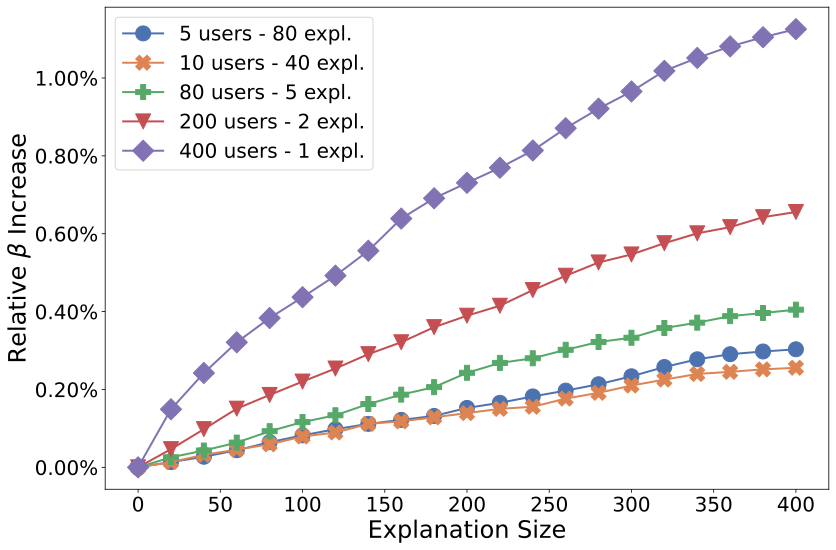

In [64]:
# exp_dir = './output/full/individual_item_side/exp2'
exp_dir = './output/full/group_item_side/exp2'
exp_filenames = ['exp2_5_80_males_20',
                 'exp2_10_40_males_20',
#                  'exp2_20_20_males_20',
#                  'exp2_40_10_males_20',
                 'exp2_80_5_males_20',
                 'exp2_200_2_males_20',
                 'exp2_400_1_males_20']
# output_dir = './plots/full/individual_item_side/exp2'
output_dir = './plots/full/group_item_side/exp2'

# markers = ['o', 'X', '*', '|', 'P', 'v', 'D']
markers = ['o', 'X', 'P', 'v', 'D']

calculate_increase = True
output_format = 'png'
user_group_0 = 0

# Pick seaborn color palette
colors = sns.color_palette('deep')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
for filename_ind in range(len(exp_filenames)):
    with open(f'{exp_dir}/{exp_filenames[filename_ind]}.tsv') as f:
        for i in range(7): f.readline() # Skip header lines
            
        lines = f.readlines()
        
        sample_size, k_nbs, nbs_per_round = int(lines[0].split()[0]),int(lines[0].split()[1]),int(lines[0].split()[2])
        item_i_id_all = np.array([np.array([int(v) for v in lines[i].split()]) for i in range(1, len(lines), 6)])
        p_U_0_i_all = np.array([np.array([float(v) for v in lines[i].split()]) for i in range(2, len(lines), 6)])
        p_U_1_i_all = np.array([np.array([float(v) for v in lines[i].split()]) for i in range(3, len(lines), 6)])
        item_ids_all = np.array([np.array([int(v) for v in lines[i].split()]) for i in range(4, len(lines), 6)])
        user_ids_all = np.array([np.array([int(v) for v in lines[i].split()]) for i in range(5, len(lines), 6)])
        
    p_U_0_i_avg = np.mean(p_U_0_i_all, axis=0)
    p_U_1_i_avg = np.mean(p_U_1_i_all, axis=0)

    numerator, denominator = (p_U_0_i_avg, p_U_1_i_avg) if user_group_0 == 0 else (p_U_1_i_avg, p_U_0_i_avg)
    
    if calculate_increase:
        y_values = ((numerator/denominator) - (numerator[0]/denominator[0]))/(numerator[0]/denominator[0])
    else:
        y_values = numerator/denominator

    # Plot PPR scores
    ax.plot(np.arange(len(y_values))*nbs_per_round,
            y_values,
            label=f"{sample_size} users - {k_nbs} expl.",
            color=colors[filename_ind],
            marker=markers[filename_ind])
    
if calculate_increase:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

ax.set_xlabel("Explanation Size")
ax.set_ylabel(r"Relative $\beta$ Increase" if calculate_increase else r"$\beta$")
ax.legend()
plt.tight_layout()

# output_filename = f'exp2_{item_i_id_all.shape[0]}_items_400_males'
output_filename = "exp2_males_to_rom_400"

plt.savefig(f"{output_dir}/{output_filename}.{output_format}")

## Experiment 3

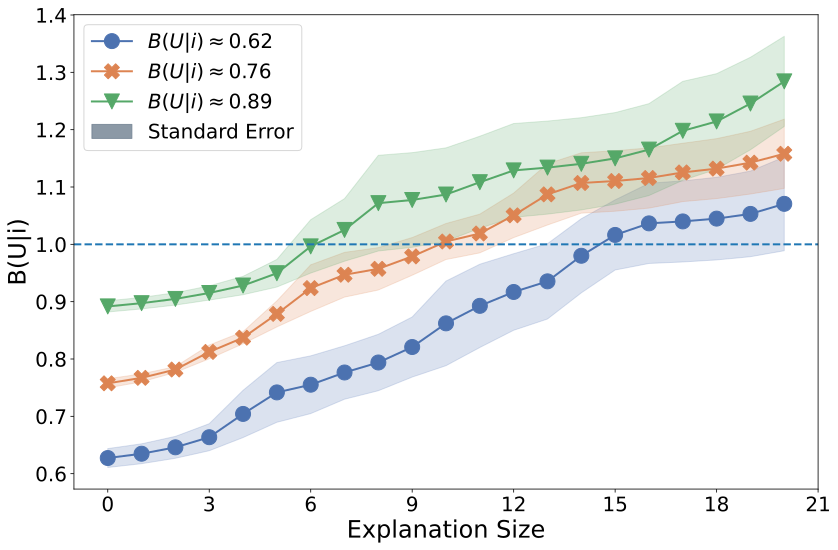

In [52]:
exp_dir = './output/full/individual_item_side/exp3'
exp_filenames = ['exp3_b_0.6_20_1',
                 'exp3_b_0.75_20_1',
                 'exp3_b_0.9_20_1']
output_dir = './plots/full/individual_item_side/exp3'
output_filename = 'exp3_avg_se'
output_format = 'pdf'

colors = sns.color_palette('deep')
markers = ['o', 'X', 'v']
fairness_value = 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
for file_ind in range(len(exp_filenames)):
    with open(f"{exp_dir}/{exp_filenames[file_ind]}.tsv") as f:
        for i in range(6): f.readline() # Skip header lines

        lines = f.readlines()

        sample_i_ids = np.array([int(lines[i]) for i in range(0, len(lines), 5)])
        p_U_0_i_all = np.array([np.array([float(v) for v in lines[i].split()]) for i in range(1, len(lines), 5)])
        p_U_1_i_all = np.array([np.array([float(v) for v in lines[i].split()]) for i in range(2, len(lines), 5)])
        user_ids_all = np.array([np.array([int(v) for v in lines[i].split()]) for i in range(3, len(lines), 5)])
        item_ids_all = np.array([np.array([int(v) for v in lines[i].split()]) for i in range(4, len(lines), 5)])

    beta_all = p_U_0_i_all/p_U_1_i_all
    beta_avg = np.mean(beta_all, axis=0)

    fairness_ind = np.argmax(beta_avg >= fairness_value)

    ax.plot(np.arange(beta_avg.shape[0]),
            beta_avg,
            color=colors[file_ind],
            marker=markers[file_ind])
    
    # Plot Standard Error
    error = np.std(beta_all, axis=0)/(beta_all.shape[0])**(1/2)
    ax.fill_between(x=np.arange(beta_avg.shape[0]),
                    y1=(beta_avg + error),
                    y2=(beta_avg - error),
                    color=colors[file_ind],
                    alpha=0.2)

ax.axhline(y=fairness_value,
           linestyle='dashed')

legend_shapes = [Line2D([0,1],[0,1], color=colors[i], marker=markers[i])
                     for i in range(len(exp_filenames))]
legend_shapes += [Patch(label='Standard Error', color='slategray', alpha=0.8)]
legend_texts = [r'$B(U|i) \approx 0.62$', r'$B(U|i) \approx 0.76$', r'$B(U|i) \approx 0.89$']
legend_texts += ['Standard Error']
ax.legend(legend_shapes, legend_texts, loc='upper left')

ax.set_xlabel('Explanation Size')
ax.set_ylabel('B(U|i)')

ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.tight_layout()

plt.savefig(f"{output_dir}/{output_filename}.{output_format}")

### Plot with titles

[0.62528757 0.63740065 0.65522697 0.68433425 0.74072936 0.89320743
 0.90382021 0.91966363 0.9458541  0.99705914 1.13994698 1.14181561
 1.14404674 1.14685555 1.15043659 1.15514989 1.16161636 1.1710949
 1.18608746 1.21484044 1.28549894]


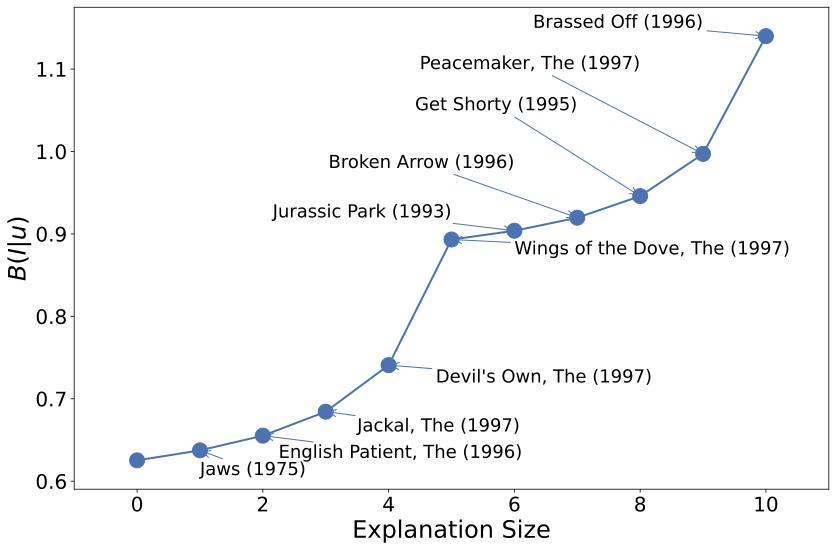

In [92]:
exp_dir = './output/full/individual_item_side/exp3'
exp_filename = 'exp3_b_0.6_20_1'
output_dir = './plots/full/individual_item_side/exp3'

output_format = 'png'

colors = sns.color_palette('deep')
offset = 0.02 # Annotation offset

with open(f"{exp_dir}/{exp_filename}.tsv", 'r') as f:
    for i in range(6): f.readline()
        
    lines = f.readlines()
    item_i_ids = np.array([int(lines[i]) for i in range(0, len(lines), 5)])
    p_U_0_i_all = np.array([np.array([float(v) for v in lines[i].split()]) for i in range(1, len(lines), 5)])
    p_U_1_i_all = np.array([np.array([float(v) for v in lines[i].split()]) for i in range(2, len(lines), 5)])
    item_ids_all = np.array([np.array([int(v) for v in lines[i].split()]) for i in range(4, len(lines), 5)])

# Manually select user to plot
item_id_ind = np.where(item_i_ids == 905)[0][0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)

beta = np.array(p_U_0_i_all[item_id_ind])/np.array(p_U_1_i_all[item_id_ind])

print(beta)

# alpha = details_df[details_df['user_id'] == user_ids[item_id_ind]]['alpha'].values[0]
# for i in range(beta.shape[0]):
#     if beta[i] >= alpha:
#         fairness_ind = i
#         break
fairness_ind = np.argmax(beta > 1)

beta = beta[:(fairness_ind + 1)]
nbs_removed_cur = item_ids_all[item_id_ind][:(fairness_ind)]

# Plot PPR
ax.plot(np.arange(beta.shape[0]),
        beta,
        color=colors[0],
        marker='o')

ax.set_xlim(-1,len(nbs_removed_cur) + 1)
ax.set_ylim(beta[0]-0.035, beta[-1]+0.035)

# Annotate with movie titles
coords = [(5, 0.92), (6, 0.98), (7, 1.05), (8, 1.1), (9, 1.15)]
for i in range(len(nbs_removed_cur)):
#     if (i % 2) == 0:
    if i < 5:
        xytext_x, xytext_y = i+1+i*0.25, beta[i+1] - 0.03 + 0.003*i
        ha_cur = 'left'
    else:
#         xytext_x, xytext_y = i+1-2.5+(i-5)*0.25, beta[i+1] + 0.02
        xytext_x, xytext_y = coords[i-5][0], coords[i-5][1]
        ha_cur = 'right'
        
    title_cur = items_df[items_df['id'] == (nbs_removed_cur[i] + 1)]['title'].values[0]
#     title_cur = '\n('.join(title_cur.split('('))
    ax.annotate(f"{title_cur}",
                xy=(i+1, beta[i+1]),
                xytext=(xytext_x, xytext_y),
                arrowprops=dict(color=colors[0], arrowstyle="->"),
                ha=ha_cur)

ax.set_xlabel('Explanation Size')
ax.set_ylabel(r'$B(I|u)$')

output_filename = f"{exp_filename}_qual_{item_i_ids[item_id_ind]}"
plt.tight_layout()
plt.savefig(f"{output_dir}/{output_filename}.{output_format}")

## Correlations

In [12]:
exp_dir = './output/full/individual_item_side/exp3'
exp_filename = 'exp3_b_0.6_20_1'
# exp_filename = 'exp3_b_0.8_20_1'
# exp_filename = 'exp3_b_0.9_20_1'
# exp_filename = 'exp3_b_0.75_20_1'


output_dir = './plots/full/individual_item_side/exp3'

output_format = 'png'

colors = sns.color_palette('deep')
offset = 0.02 # Annotation offset

with open(f"{exp_dir}/{exp_filename}.tsv", 'r') as f:
    for i in range(6): f.readline()
        
    lines = f.readlines()
    item_i_ids = np.array([int(lines[i]) for i in range(0, len(lines), 5)])
    p_U_0_i_all = np.array([np.array([float(v) for v in lines[i].split()]) for i in range(1, len(lines), 5)])
    p_U_1_i_all = np.array([np.array([float(v) for v in lines[i].split()]) for i in range(2, len(lines), 5)])
    user_ids_all = np.array([np.array([int(v) for v in lines[i].split()]) for i in range(3, len(lines), 5)])
    item_ids_all = np.array([np.array([int(v) for v in lines[i].split()]) for i in range(4, len(lines), 5)])
    
# for i in range(item_i_ids.shape[0]):
#     print(item_i_ids[i])
#     i_nbs = np.nonzero(R[:, np.where(item_original_ids == item_i_ids[i])[0][0]])[0]
#     for nb in i_nbs:
#         print(np.sum(R[nb, :]), end=',')
#     print(f"Item pop: {np.sum(R[:, np.where(item_original_ids == item_i_ids[i])[0][0]])}")
#     cur_users = np.unique(user_ids_all[i])
#     print(f"Action: {[np.sum(R[u_id, item_group_mapped_ids_0]) for u_id in cur_users]}")
#     print(f"Romance: {[np.sum(R[u_id, item_group_mapped_ids_1]) for u_id in cur_users]}")
#     print('----')
    
for i in range(item_i_ids.shape[0]):
    print([np.sum(R[male_mapped_ids, np.where(item_original_ids==j)[0][0]]) for j in item_ids_all[i]])
    print([np.sum(R[female_mapped_ids, np.where(item_original_ids==j)[0][0]]) for j in item_ids_all[i]])
    print('---')
#     pearson_res = pearsonr(np.arange(cur_removed.shape[0]),
#                            [np.sum(R[female_mapped_ids, np.where(item_original_ids == j)[0][0]])
#                             for j in cur_removed])
#     print(f"{pearson_res.statistic} ({pearson_res.pvalue})")

[329, 194, 65, 42, 13, 6, 3, 329, 101, 194, 305, 176, 167, 127, 53, 329, 194, 111, 305, 65]
[152, 61, 31, 33, 5, 4, 4, 152, 26, 61, 126, 35, 73, 48, 11, 152, 61, 57, 126, 31]
---
[216, 329, 60, 169, 42, 199, 202, 164, 108, 22, 305, 329, 111, 194, 53, 33, 33, 10, 65, 13]
[64, 152, 27, 71, 33, 62, 52, 45, 28, 10, 126, 152, 57, 61, 11, 19, 14, 15, 31, 5]
---
[194, 30, 329, 305, 101, 169, 65, 176, 100, 41, 19, 65, 13, 23, 115, 329, 329, 305, 194, 176]
[61, 9, 152, 126, 26, 71, 31, 35, 24, 12, 9, 31, 5, 8, 28, 152, 152, 126, 61, 35]
---
[108, 305, 60, 55, 329, 167, 176, 127, 253, 305, 115, 101, 176, 305, 55, 19, 194, 65, 41, 33]
[28, 126, 27, 17, 152, 73, 35, 48, 78, 126, 28, 26, 35, 126, 17, 8, 61, 31, 12, 18]
---
[194, 65, 305, 176, 167, 127, 41, 101, 35, 30, 100, 33, 19, 13, 194, 108, 16, 27, 27, 13]
[61, 31, 126, 35, 73, 48, 12, 26, 9, 9, 24, 18, 9, 5, 61, 28, 3, 7, 8, 5]
---


# Group-level

---

## Experiment1

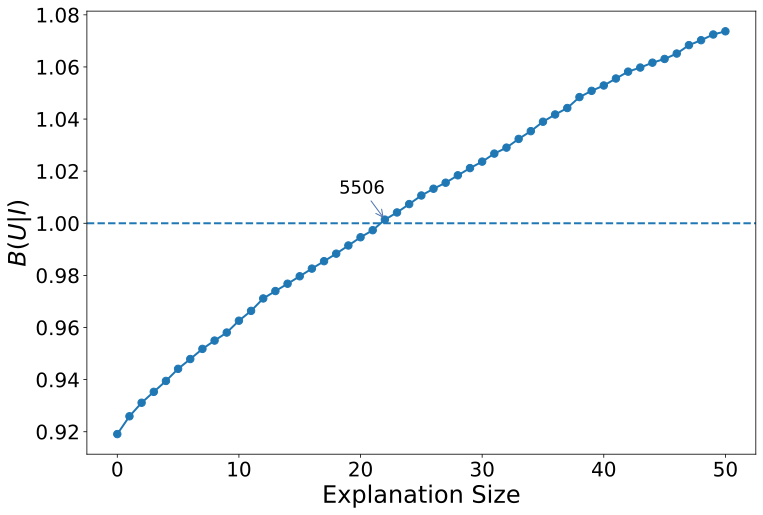

In [21]:
exp_dir = './output/full/group_item_side/exp1'
# exp_filename = 'exp1_50_avg_delta'
# exp_filename = 'exp1_50_avg_diff'
exp_filename = 'exp1_50_sum_delta'
# exp_filename = 'exp1_50_sum_diff'
output_dir = './plots/full/group_item_side/exp1'
output_format = 'pdf'

colors = sns.color_palette('deep')

calculate_increase = False

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(4): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_1_I_0 = np.array([float(v) for v in lines[1].split()])
    item_ids = np.array([int(v) for v in lines[2].split()])

beta = p_U_0_I_0/p_U_1_I_0

if calculate_increase:
    y_values = (beta - beta[0])/beta[0]
else:
    y_values = beta
    
fairness_ind = np.argmax(y_values > 1)
    
# Calcualate num of edges removed from U_0 to cur_item_x
num_edges_removed = []
for item_id in item_ids:
    item_mapped_id = np.where(item_original_ids == item_id)[0][0]
    num_edges_removed.append(np.count_nonzero(R[male_mapped_ids[:, np.newaxis], item_mapped_id]))

num_edges_removed = np.cumsum(num_edges_removed)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
ax.plot(np.arange(beta.shape[0]),
        y_values,
        marker='.')

ax.annotate(f"{num_edges_removed[fairness_ind]}",
            xy=(fairness_ind, y_values[fairness_ind]),
            xytext=(fairness_ind, y_values[fairness_ind] + 0.01),
            arrowprops=dict(color=colors[0], arrowstyle="->"),
            ha='right')

ax.axhline(y=1,
           linestyle='dashed')

ax.set_xlabel('Explanation Size')
ax.set_ylabel(r'$B(U|I)$')

if calculate_increase:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
# ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.savefig(f"{output_dir}/{exp_filename}.{output_format}")

### Correlations

In [64]:
exp_dir = './output/full/group_item_side/exp1'
exp_filename = 'exp1_50_sum_delta'

colors = sns.color_palette('deep')

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(4): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_1_I_0 = np.array([float(v) for v in lines[1].split()])
    item_ids = np.array([int(v) for v in lines[2].split()])
    
item_degrees_U_0, item_degrees_U_1 = [], []
for i_id in item_ids:
    i_mapped_id = np.where(item_original_ids == i_id)[0][0]
    item_degrees_U_0.append(np.count_nonzero(R[male_mapped_ids, i_mapped_id]))
    item_degrees_U_1.append(np.count_nonzero(R[female_mapped_ids, i_mapped_id]))
    
print('#### Experiment 1 (removing items) ####')
pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       item_degrees_U_0)
print(f"> item degree in U_0 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       item_degrees_U_1)
print(f"> item degree in U_1 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       np.array(item_degrees_U_0) + np.array(item_degrees_U_1))
print(f"> item degree overall - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

#### Experiment 1 (removing items) ####
> item degree in U_0 - rank:
	-0.8371109803806668 (3.6082039884450363e-14)
> item degree in U_1 - rank:
	-0.8315957739439952 (7.511615863444851e-14)
> item degree overall - rank:
	-0.8580189609351262 (1.7109277540254842e-15)


## Experiment 3

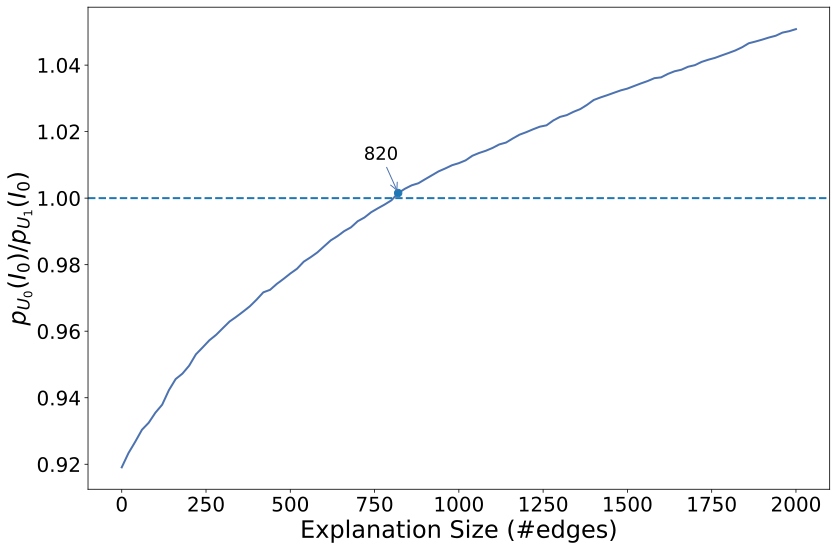

In [11]:
exp_dir = './output/full/group_item_side/exp3'
exp_filename = 'exp3_2000_20'
output_dir = './plots/full/group_item_side/exp3'
output_format = 'png'

colors = sns.color_palette('deep')

calculate_increase = False

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(5): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_1_I_0 = np.array([float(v) for v in lines[1].split()])
    user_ids = np.array([int(v) for v in lines[2].split()])
    item_ids = np.array([int(v) for v in lines[3].split()])

beta = p_U_0_I_0/p_U_1_I_0

if calculate_increase:
    y_values = (beta - beta[0])/beta[0]
    fairness_value = (1 - beta[0])/beta[0]
else:
    y_values = beta
    fairness_value = 1
    
fairness_ind = np.argmax(y_values >= fairness_value)
edges_per_round = int(exp_filename.split('_')[-1])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
ax.plot(np.arange(beta.shape[0])*edges_per_round,
        y_values,
        color=colors[0])

ax.plot([edges_per_round*fairness_ind], [y_values[fairness_ind]], '.')

ax.annotate(f"{edges_per_round*fairness_ind}",
            xy=(fairness_ind*edges_per_round, y_values[fairness_ind]),
            xytext=(fairness_ind*edges_per_round, y_values[fairness_ind] + 0.01),
            arrowprops=dict(color=colors[0], arrowstyle="->"),
            ha='right')

ax.set_xlabel('Explanation Size (#edges)')
ax.set_ylabel(r'$B(U|I)$')

ax.axhline(y=fairness_value,
           linestyle='dashed')

if calculate_increase:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.tight_layout()
# plt.savefig(f"{output_dir}/{exp_filename}.{output_format}")

## Experiment 4

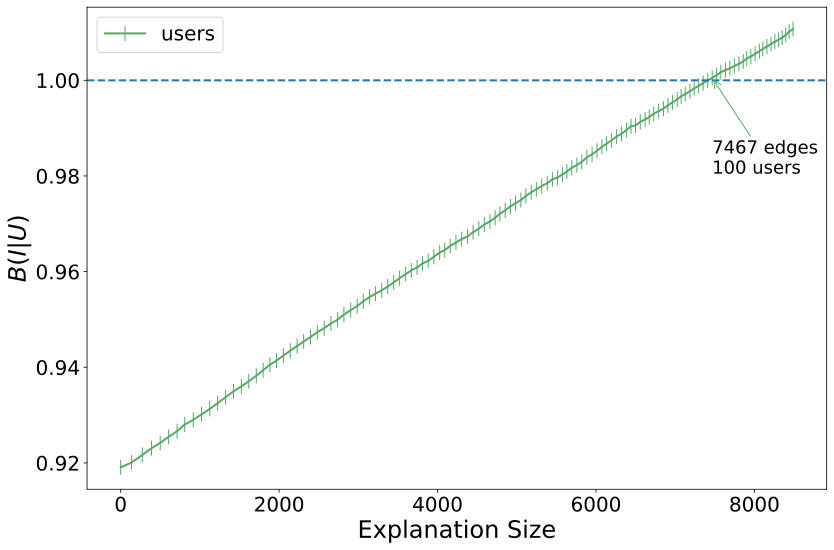

In [19]:
exp_dir = './output/full/group_item_side/exp4'
output_dir = './plots/full/group_item_side/exp4'
output_format = '.png'
exp_filename = 'exp4_120_males'

calculate_increase = False
colors = sns.color_palette('deep')
with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(4): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_1_I_0 = np.array([float(v) for v in lines[1].split()])
    user_ids = np.array([int(v) for v in lines[2].split()])

beta = p_U_0_I_0/p_U_1_I_0

y_values, fairness_value = ((beta - beta[0])/beta[0], (1 - beta[0])/beta[0]) if calculate_increase else (beta, 1)
    
fairness_ind = np.argmax(y_values >= fairness_value)
# fairness_ind = -1

# Calcualate num of edges removed from U_0 to I_1
num_edges_removed = [0] # Start with 0 for initial score
for user_id in user_ids:
    user_mapped_id = np.where(user_original_ids == user_id)[0][0]
    num_edges_removed.append(np.count_nonzero(R[user_mapped_id, item_group_mapped_ids_0]))

num_edges_removed = np.cumsum(num_edges_removed)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)

ax.plot(num_edges_removed, y_values, marker='|', color=colors[2], label='users')
ax.annotate(f"{num_edges_removed[fairness_ind]} edges\n{fairness_ind} users",
            xy=(num_edges_removed[fairness_ind], y_values[fairness_ind]),
            xytext=(num_edges_removed[fairness_ind], y_values[fairness_ind] - 0.02),
            arrowprops=dict(color=colors[2], arrowstyle="->"),
            ha='left')

ax.set_xlabel('Explanation Size')
ax.set_ylabel(r'$B(U|I)$')

ax.axhline(y=fairness_value,
           linestyle='dashed')
ax.legend()
plt.savefig(f"{output_dir}/{exp_filename}.{output_format}")
plt.tight_layout()

## Experiment 1, 3, 4 combined

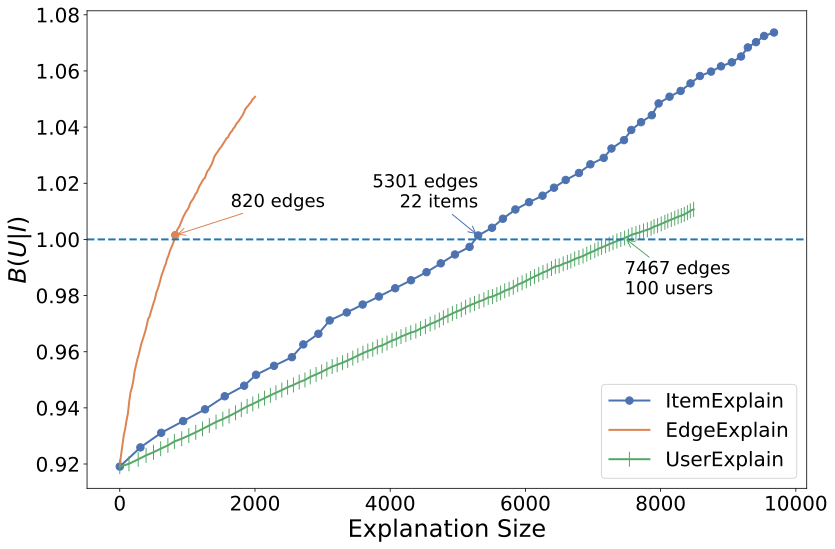

In [7]:
exp_paths = ['./output/full/group_item_side/exp1/exp1_50_sum_delta',
             './output/full/group_item_side/exp3/exp3_2000_20',
             './output/full/group_item_side/exp4/exp4_120_males']
output_dir = './plots/full/group_item_side/exp_1_3_4_combined'
output_format = 'pdf'

colors = sns.color_palette('deep')

fairness_value = 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
# READ AND PLOT EXPERIMENT 1
with open(f"{exp_paths[0]}.tsv") as f:
    for i in range(4): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_1_I_0 = np.array([float(v) for v in lines[1].split()])
    item_ids = np.array([int(v) for v in lines[2].split()])

beta = p_U_0_I_0/p_U_1_I_0

y_values = beta
    
fairness_ind = np.argmax(y_values > fairness_value)
    
# Calcualate num of edges removed from U_0 to cur_item_x
num_edges_removed = [0]
for item_id in item_ids:
    item_mapped_id = np.where(item_original_ids == item_id)[0][0]
    num_edges_removed.append(np.count_nonzero(R[male_mapped_ids[:, np.newaxis], item_mapped_id]))

num_edges_removed = np.cumsum(num_edges_removed)

ax.plot(num_edges_removed, y_values, marker='.', color=colors[0], label='ItemExplain')
ax.annotate(f"{num_edges_removed[fairness_ind]} edges\n{fairness_ind} items",
            xy=(num_edges_removed[fairness_ind], y_values[fairness_ind]),
            xytext=(num_edges_removed[fairness_ind], y_values[fairness_ind] + 0.01),
            arrowprops=dict(color=colors[0], arrowstyle="->"),
            ha='right')

# READ AND PLOT EXPERIMENT 3
with open(f"{exp_paths[1]}.tsv") as f:
    for i in range(5): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_1_I_0 = np.array([float(v) for v in lines[1].split()])
    user_ids = np.array([int(v) for v in lines[2].split()])
    item_ids = np.array([int(v) for v in lines[3].split()])

beta = p_U_0_I_0/p_U_1_I_0
y_values = beta

fairness_ind = np.argmax(y_values >= fairness_value)
edges_per_round = int(exp_paths[1].split('_')[-1])

ax.plot(np.arange(beta.shape[0])*edges_per_round,
        y_values,
        color=colors[1],
        label='EdgeExplain')

ax.plot([edges_per_round*fairness_ind], [y_values[fairness_ind]], marker='.', color=colors[1])

ax.annotate(f"{edges_per_round*fairness_ind} edges",
            xy=(fairness_ind*edges_per_round, y_values[fairness_ind]),
            xytext=(fairness_ind*(edges_per_round*2), y_values[fairness_ind] + 0.01),
            arrowprops=dict(color=colors[1], arrowstyle="->"),
            ha='left')

# READ AND PLOT EXPERIMENT 4
with open(f"{exp_paths[2]}.tsv") as f:
    for i in range(4): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_1_I_0 = np.array([float(v) for v in lines[1].split()])
    user_ids = np.array([int(v) for v in lines[2].split()])
    
beta = p_U_0_I_0/p_U_1_I_0
y_values = beta

fairness_ind = np.argmax(y_values >= fairness_value)

# Calcualate num of edges removed from U_0 to I_1
num_edges_removed = [0] # Start with 0 for initial score
for user_id in user_ids:
    user_mapped_id = np.where(user_original_ids == user_id)[0][0]
    num_edges_removed.append(np.count_nonzero(R[user_mapped_id, item_group_mapped_ids_0]))

num_edges_removed = np.cumsum(num_edges_removed)

ax.plot(num_edges_removed, y_values, marker='|', color=colors[2], label='UserExplain')
ax.annotate(f"{num_edges_removed[fairness_ind]} edges\n{fairness_ind} users",
            xy=(num_edges_removed[fairness_ind], y_values[fairness_ind]),
            xytext=(num_edges_removed[fairness_ind], y_values[fairness_ind] - 0.02),
            arrowprops=dict(color=colors[2], arrowstyle="->"),
            ha='left')

ax.axhline(y=fairness_value,
           linestyle='dashed')

ax.set_xlabel('Explanation Size')
ax.set_ylabel(r'$B(U|I)$')

ax.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/exp_1_3_4_combined.{output_format}")